# Train Agent on Unity Environment

---

## Start the Environment

Below assumes that one has followed the instruction on the README file such that the Unity environment is ready.

In [1]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# Training

---

## Initialization

Import required libraries.

In [4]:
import torch
import random
import time
import numpy as np
from collections import deque
from dqn_agent import Agent

A helper function to calculate elapsed time during training.

In [5]:
def get_minutes_and_seconds_from_start_time(start_time):
    elapsed_seconds = int(time.time() - start_time)
    minutes = elapsed_seconds // 60
    seconds = elapsed_seconds - (minutes * 60)
    return minutes, seconds

A function to train a variation of DQN.

In [6]:
def dqn(env, 
        brain_name, 
        n_episodes=2000,
        max_t=1000,
        min_score_to_pass=13,
        print_every=100,
        eps_start=1.0, 
        eps_end=0.01, 
        eps_decay=0.995,
        model_path="model.pt",
        use_double_dqn=False,
        use_dueling_dqn=False):
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # get state size
    state_size = len(env_info.vector_observations[0])

    # get action size
    action_size = brain.vector_action_space_size

    # initialize agent
    agent = Agent(state_size=state_size, action_size=action_size, seed=0, use_double_dqn=use_double_dqn, use_dueling_dqn=use_dueling_dqn)

    # initialize learning settings
    epsilon = eps_start

    # initialize scores
    scores = []
    scores_window = deque(maxlen=100) # store last 100 scores for averaging

    # start timer
    start_time = time.time()

    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=True)[brain_name]

        # observe initial state
        state = env_info.vector_observations[0]

        # reset score
        score = 0

        for _ in range(max_t):
            # select an action according to the agent's policy
            action = agent.act(state, epsilon)

            # send the action to the environment
            env_info = env.step(action)[brain_name]

            # observe the next state
            next_state = env_info.vector_observations[0]

            # observe the reward
            reward = env_info.rewards[0]

            # see if episode has finished
            done = env_info.local_done[0]

            # send transition to the agent
            agent.store_transition(state, action, reward, next_state, done)

            # accumulate score
            score += reward

            # roll over the state to the next time step
            state = next_state

            # exit loop if episode finished
            if done:
                break

        # update epsilon
        epsilon = max(eps_end, epsilon * eps_decay)

        # save score
        scores.append(score)
        scores_window.append(score)

        # print stats
        average_score = np.mean(scores_window)
        print("\rEpisode {:4} - Average Score: {:.2f}".format(i_episode, average_score), end="")

        if i_episode % print_every == 0:
            print("\rEpisode {:4} - Average Score: {:.2f}".format(i_episode, average_score))

            minutes, seconds = get_minutes_and_seconds_from_start_time(start_time)
            print("{:2} minutes {:2} seconds have elapsed".format(minutes, seconds))

        # stop training once average score reaches the threshold of 13 over 100 consecutive episodes
        if average_score >= min_score_to_pass:
            print("\rEnvironment is solved in {:4} episodes! - Final average score: {:.2f}".format(i_episode, average_score))

            minutes, seconds = get_minutes_and_seconds_from_start_time(start_time)
            print("{:2} minutes {:2} seconds have elapsed".format(minutes, seconds))

            # save the model weights
            torch.save(agent.qnetwork_local.state_dict(), model_path)

            break
    
    return scores

A function to plot the scores obtained from the training fuction.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_scores(scores, title=""):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.title(title)
    plt.xlabel("Number of Episodes")
    plt.ylabel("Score")
    plt.show() 

## Deep Q-Network
### 1. Background

Deep Q-Network uses a deep neural network to approximate action value functions and trains using experience replay. My model is comprised of three fully connected layers of size 32, 64, and 4, respectively. The first two numbers were chosen after trying different combinations of 32, 64, and 128 for the first two hidden layers because this combination appeared to be the most optimal for the model in 3 minutes of training. The last number i.e. 4 is the number of actions the agent can take.

I used a fixed size buffer to store experience tuples as the one given in the Deep Q-Networks lesson applied to an OpenAI Gym task because it seemed to work optimally. The buffer stores up to one hundred thousand experience tuples. At each iteration of the game, I stored the experience tuple in the buffer. 

One important aspect of Deep Q-Network is the use of a different network as the target action values. This stabilizes learning as the target action values do not fluctuate abruptly during training. Instead of updating the weights of target network with the weights of the latest version of the main network, I soft updated the weights in that I added fractions of the main network weights to the target network weights. This allows for smoother transition from the old weights to the new weights.

Every 4 iterations, the agent samples and learn from 64 experience tuples to update its main network.

To learn further about Deep Q-Network, refer to this [paper](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf).

### 2. Train the Agent

In [8]:
scores = dqn(env, brain_name, model_path="model-dqn.pt")

Episode  100 - Average Score: 0.796
 1 minutes 39 seconds have elapsed
Episode  200 - Average Score: 3.96
 3 minutes  6 seconds have elapsed
Episode  300 - Average Score: 6.88
 4 minutes 44 seconds have elapsed
Episode  400 - Average Score: 9.22
 6 minutes 25 seconds have elapsed
Episode  500 - Average Score: 12.25
 8 minutes  3 seconds have elapsed
Environment is solved in  555 episodes! - Final average score: 13.06
 8 minutes 53 seconds have elapsed


### 3. Plot Scores
Plot the agent's scores to see how the average score changes during training. Increasing score indicates that the agent indeed learns as expected.

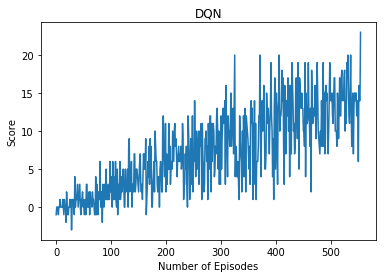

In [9]:
plot_scores(scores, "DQN")

## Double Deep Q-Network
### 1. Background

Double Deep Q-Network is an extension of Deep Q-Network with one main improvement:

The decoupling of action selection and action evaluation of the target in computing the loss.

I used the main network to select an action, while I used the target network to evaluate the selected action.

To learn further about Double Deep Q-Network, refer to this [paper](https://arxiv.org/abs/1509.06461).

### 2. Train the Agent

In [10]:
scores = dqn(env, brain_name, model_path="model-double-dqn.pt", use_double_dqn=True)

Episode  100 - Average Score: 0.923
 1 minutes 33 seconds have elapsed
Episode  200 - Average Score: 5.05
 3 minutes  1 seconds have elapsed
Episode  300 - Average Score: 8.32
 4 minutes 33 seconds have elapsed
Episode  400 - Average Score: 11.12
 6 minutes  5 seconds have elapsed
Episode  500 - Average Score: 12.19
 7 minutes 45 seconds have elapsed
Environment is solved in  530 episodes! - Final average score: 13.03
 8 minutes 15 seconds have elapsed


### 3. Plot Scores
Plot the agent's scores to see how the average score changes during training. Increasing score indicates that the agent indeed learns as expected.

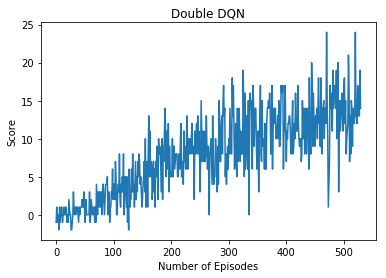

In [11]:
plot_scores(scores, "Double DQN")

## Dueling Deep Q-Network
### 1. Architecture

Dueling Deep Q-Network is designed to learn faster by decoupling the state value stream and the action advantage stream in that it only learns action values when they are necessary at any given state.

The value stream is composed of two fully connected layers with 32 and 1 hidden units, respectively. 32 is taken arbitrarily as the Deep Q-Network uses 32 hidden units for its first layer, while 1 is the number of values per state.

The action advantage stream is composed of two fully connected layers with 32 and 4 hidden units, respectively. 32 is also taken arbitrarily, while 4 is the number of actions per state.

The two streams are combined by adding the state value to the difference between the predicted action advantages and their corresponding averages. As training time approaches infinity, the action values should converge to state values plus some constant. This non-zero constant increases stability of the optimization.

To learn further about Double Deep Q-Network, refer to this [paper](https://arxiv.org/abs/1511.06581).

### 2. Train the Agent

In [12]:
scores = dqn(env, brain_name, model_path="model-dueling-dqn.pt", use_dueling_dqn=True)

Episode  100 - Average Score: 0.672
 1 minutes 37 seconds have elapsed
Episode  200 - Average Score: 4.51
 3 minutes 15 seconds have elapsed
Episode  300 - Average Score: 8.59
 4 minutes 53 seconds have elapsed
Episode  400 - Average Score: 10.74
 6 minutes 32 seconds have elapsed
Episode  500 - Average Score: 11.95
 8 minutes 12 seconds have elapsed
Environment is solved in  550 episodes! - Final average score: 13.00
 9 minutes  2 seconds have elapsed


### 3. Plot Scores
Plot the agent's scores to see how the average score changes during training. Increasing score indicates that the agent indeed learns as expected.

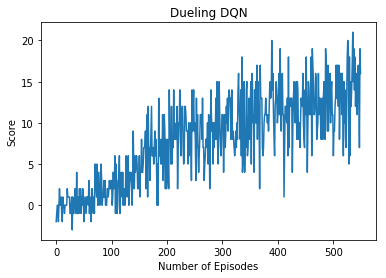

In [13]:
plot_scores(scores, "Dueling DQN")

## Double Dueling Deep Q-Network
### 1. Architecture

This network combines Double Deep Q-Network and Dueling Deep Q-Network.

### 2. Train the Agent

In [14]:
scores = dqn(env, brain_name, model_path="model-double-dueling-dqn.pt", use_dueling_dqn=True, use_double_dqn=True)

Episode  100 - Average Score: 0.282
 1 minutes 32 seconds have elapsed
Episode  200 - Average Score: 4.23
 3 minutes  5 seconds have elapsed
Episode  300 - Average Score: 8.03
 4 minutes 34 seconds have elapsed
Episode  400 - Average Score: 9.29
 6 minutes  1 seconds have elapsed
Episode  500 - Average Score: 11.54
 7 minutes 31 seconds have elapsed
Environment is solved in  571 episodes! - Final average score: 13.01
 8 minutes 37 seconds have elapsed


### 3. Plot Scores
Plot the agent's scores to see how the average score changes during training. Increasing score indicates that the agent indeed learns as expected.

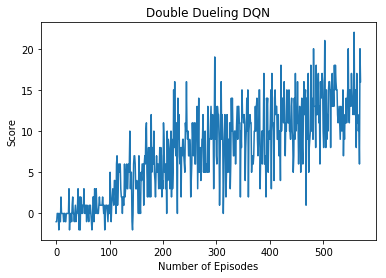

In [15]:
plot_scores(scores, "Double Dueling DQN")

# Result

---

The plots above show that all agents learn within 8 to 9 minutes to get an average score of 13  over 100 consecutive episodes. Although Double DQN and Dueling DQN should be an improvement over Vanilla DQN, the results above indicate otherwise. This is likely due to non optimal hyperparameters. Furthermore, learning more complex states i.e. raw pixels might allow the two extensions of DQN to improve over DQN.

# Future Work

---

Firstly, a hyperparameter search such as grid search or random search can be done to tune the parameters to further improve the model. 

Moreover, one can implement a [prioritized experience replay](https://arxiv.org/abs/1511.05952) to investigate whether it will improve the agent's performance or not.

Lastly, one can train an agent from raw pixels which requires updating the neural network to use a Convolutional Neural Network.